/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


UMPM
elapsed 6.464578151702881


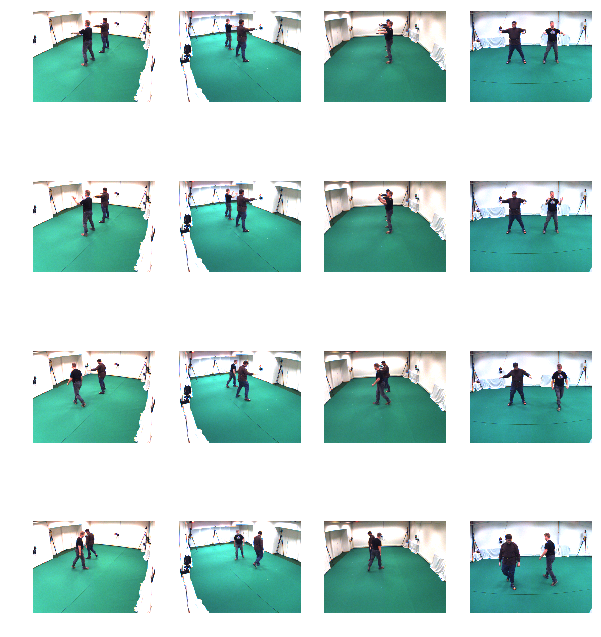

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '.')
import paf_loader
from os.path import join, isdir, isfile
import numpy as np
import cv2
from cselect import color as cs
from time import time

from mvpose.data import umpm

root = join(Settings['data_root'], 'pak')
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']
tmp = Settings['tmp']

_start = time()
X, Y, Calib = umpm.get(root, 'p2_free_1', user, pwd)

# **************************** #
FRAMES = [0, 60, 120, 180]
# **************************** #

def get_track(FRAMES):
    Ims = []
    Hms = []
    Pafs = []
    
    im_name = 'umpm_f' + '_'.join([str(s) for s in FRAMES]) + 'im.npy'
    hm_name = 'umpm_f' + '_'.join([str(s) for s in FRAMES]) + 'hm.npy'
    pf_name = 'umpm_f' + '_'.join([str(s) for s in FRAMES]) + 'pf.npy'
    im_name = join(tmp, im_name)
    hm_name = join(tmp, hm_name)
    pf_name = join(tmp, pf_name)
    
    if isfile(im_name) and isfile(hm_name) and isfile(pf_name):
        Ims = np.load(im_name)
        Hms = np.load(hm_name)
        Pafs = np.load(pf_name)
    else:
        for frame in FRAMES:
            print('load frame ', frame)
            Im = np.array([X[0][frame], X[1][frame], X[2][frame], X[3][frame]])
            Ims.append(Im)
            heatmaps, pafs = paf_loader.load_confidence_map_and_paf('umpm', 
                                                                Im, 
                                                                frame, 
                                                                dir=tmp)
            Hms.append(heatmaps)
            Pafs.append(pafs)

        Ims = np.array(Ims)
        Hms = np.array(Hms)
        Pafs = np.array(Pafs)
        np.save(im_name, Ims)
        np.save(hm_name, Hms)
        np.save(pf_name, Pafs)
        
    return Ims, Hms, Pafs

Ims, Hms, Pafs = get_track(FRAMES)
_end = time()
print('elapsed', _end - _start)

fig = plt.figure(figsize=(10,12))
n = len(FRAMES)
for frame, Im in enumerate(Ims):
    for cid in range(4):
        ax = fig.add_subplot(n, 4, frame*4+cid+1)
        ax.axis('off')
        ax.imshow(Im[cid])

plt.show()

In [2]:
# def get_bb(cam, human, w, h):
#     """
#         gets the aabb from the human using the camera
#     :param cam:
#     :param human:
#     :param w: image width
#     :param h: image height
#     :return:
#     """
#     points3d = []
#     for joints in human:
#         if joints is not None:
#             points3d.append(joints)
#     points2d = cam.projectPoints(np.array(points3d))
#     points2d = np.round(points2d)
#     max_x = np.clip(int(np.max(points2d[:, 0])), a_max=w-1, a_min=0)
#     min_x = np.clip(int(np.min(points2d[:, 0])), a_max=w-1, a_min=0)
#     max_y = np.clip(int(np.max(points2d[:, 1])), a_max=w-1, a_min=0)
#     min_y = np.clip(int(np.min(points2d[:, 1])), a_max=w-1, a_min=0)
#     return min_x, min_y, max_x, max_y
    
# tx, ty, bx, by = get_bb(Calib[0], humans[0][0], 600, 500)

# im = Im[0]

# fig = plt.figure(figsize=(16, 10))
# ax = fig.add_subplot(111)
# ax.imshow(im)
# ax.plot([tx, tx, bx, bx, tx], [ty, by, by, ty, ty], color='red')
# plt.show()

could not find model.. downloading it
loading settings: 100.45940208435059
handling frame  0
	elapsed 1.8462731838226318
handling frame  1
	elapsed 1.877284049987793
handling frame  2
	elapsed 1.8309121131896973
handling frame  3
	elapsed 1.7935922145843506
	[gp:step 1] elapsed 0.03293466567993164
		# boxes to compare: 144
	[gp:step 2] elapsed 145.95572972297668
	[gp:step 3] elapsed 0.00018525123596191406
		# nodes in 3D graph: 16
-------------------------------------------
		Time =  4  ms
		result: 0

		Total cost: 36.828061992199274
(0, 0)--(1, 0),  1.0
(0, 1)--(1, 1),  1.0
(0, 0)--(2, 0),  1.0
(0, 0)--(2, 1),  0.0
(0, 1)--(2, 1),  1.0
(0, 0)--(3, 0),  0.0
(0, 0)--(3, 1),  1.0
(0, 1)--(3, 0),  1.0
(0, 1)--(3, 1),  0.0
(1, 0)--(2, 0),  1.0
(1, 1)--(2, 1),  1.0
(1, 0)--(3, 0),  1.0
(1, 1)--(3, 0),  0.0
(1, 1)--(3, 1),  1.0
(2, 0)--(3, 0),  1.0
(2, 1)--(3, 1),  1.0
graph partitioning: elapsed 145.9953417778015
parse partitioning 7.843971252441406e-05
elapsed 153.34575700759888


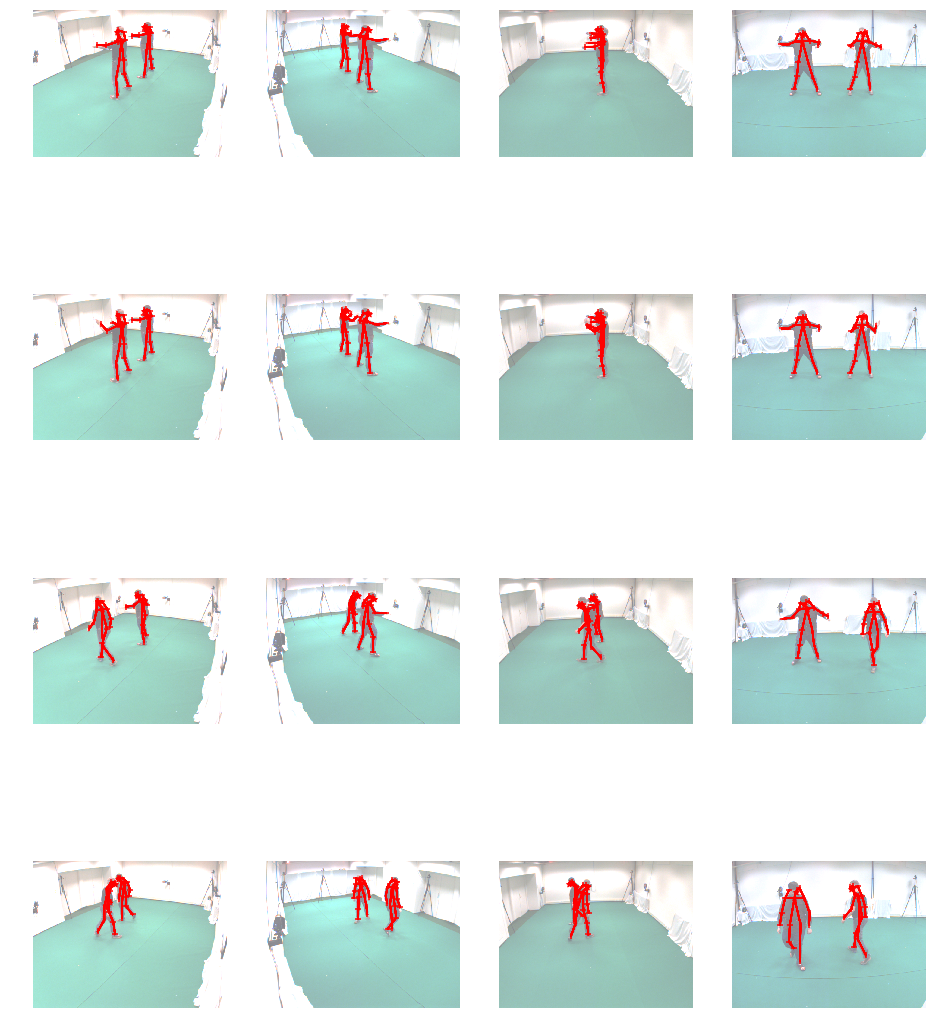

In [3]:
from mvpose.tracking import track
from mvpose.algorithm.settings import get_settings, get_tracking_settings
from mvpose.plot.limbs import draw_mscoco_human
from reid import reid

# =============================
_start = time()
params = get_settings()
# url = 'http://188.138.127.15:81/models/model_heavy_umpm.h5'
# name = 'model_heavy_umpm.h5'
# reid_model = reid.ReId(url=url, name=name)
reid_model = reid.ReId()
tracking_params = get_tracking_settings(params, 
                                        low_spec_mode=True, 
                                        reid_model=reid_model,
                                        personreid_batchsize=2)
_end = time()
print("loading settings:", _end - _start)

_start = time()
Debug, tracks, humans = track([Calib], Ims, Hms, Pafs, 
                              tracking_setting=tracking_params,
                              debug=True)
_end = time()
print('elapsed', _end - _start)
# =============================

n_persons = np.max(tracks) + 1  # as we start counting with zero
n_frames = Debug.n_frames
n_joints = Debug.n_joints


colors = cs.rangecolor(n_persons, (255, 0, 0), (0, 0, 255))/255

fig = plt.figure(figsize=(16,20))

_ct = 1
for frame, (Humans, track, Im) in enumerate(zip(humans, tracks, Ims)):
    assert len(track) == len(Humans)
    for cid, cam in enumerate(Calib):
        h,w,_ = Im[cid].shape
        ax = fig.add_subplot(n_frames, 4, _ct); ax.axis('off')
        ax.set_xlim([0, w])
        ax.set_ylim([h, 0])
        _ct += 1; ax.imshow(Im[cid], alpha=0.5)
        
        for pid, human in zip(track, Humans):
            color = 'black' if pid == -1 else colors[pid]
            draw_mscoco_human(ax, human, cam, color=color)


plt.show()

In [4]:
Debug.track_partitioning.costs

{(0, 0, 1, 0): 7.084926494758195,
 (0, 1, 1, 1): 1.489291836429532,
 (0, 0, 2, 0): 7.243851987480891,
 (0, 0, 2, 1): 4.659994727821018,
 (0, 1, 2, 1): 1.7951844303431193,
 (0, 0, 3, 0): 2.905920287233914,
 (0, 0, 3, 1): 3.2659129051677116,
 (0, 1, 3, 0): 1.5025186147999332,
 (0, 1, 3, 1): 1.1171023540924887,
 (1, 0, 2, 0): 6.0344661031994695,
 (1, 1, 2, 1): 1.7069143003971228,
 (1, 0, 3, 0): 2.264916278514431,
 (1, 1, 3, 0): 1.37388392432342,
 (1, 1, 3, 1): 1.0374833259969256,
 (2, 0, 3, 0): 2.406907196336748,
 (2, 1, 3, 1): 0.9956885187751979}

In [5]:
G = Debug.track_partitioning.G

import networkx as nx
comp = list(nx.connected_components(G))

comp

for _com in comp:
    for nid in _com:
        node = G.nodes[nid]
        print(nid, node['key'])
    print('----')

print(G.edges)

1 (0, 0)
2 (0, 1)
3 (1, 0)
4 (1, 1)
5 (2, 0)
6 (2, 1)
7 (3, 0)
8 (3, 1)
----
[(1, 3), (1, 5), (1, 8), (2, 4), (2, 6), (2, 7), (3, 5), (3, 7), (4, 6), (4, 8), (5, 7), (6, 8)]


In [6]:
Debug.track_partitioning.added_constraints 

AttributeError: 'GraphPartitioningTracker' object has no attribute 'added_constraints'

In [ ]:
import cv2 
from numpy.random import randint

graph_part = Debug.track_partitioning

scores = graph_part.scores
imgsA = graph_part.ImgsA
imgsB = graph_part.ImgsB

print(len(imgsA))

idxs = randint(0, len(imgsA), 7)
n = len(idxs)
fig = plt.figure(figsize=(10, n * 3))

for j, i in enumerate(idxs):
    ax = fig.add_subplot(n, 1, j+1); ax.axis('off')
    imgA = cv2.resize(imgsA[i], (64, 128))
    imgB = cv2.resize(imgsB[i], (64, 128))
    score = scores[i]
    img = np.concatenate([imgA, imgB], axis=1)
    ax.set_title('score=' + str(score))
    ax.imshow(img)